In [15]:
from transformers import AutoTokenizer
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import os
import numpy as npz
from transformers import BertForSequenceClassification, AdamW
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


In [16]:
from transformers import AutoModel

model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

In [17]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text = "HOLAOGHOAL GOOAL"
token = tokenizer.encode(text)
print(token)

[101, 7570, 2721, 8649, 6806, 2389, 27571, 2389, 102]


In [18]:

df = pd.read_csv('./IMDB Dataset.csv')



In [19]:

class imbd_dataset(Dataset):
    def __init__(self, csv, tokenizer):
        df = pd.read_csv(csv)
        df['sentiment'] = np.where(df['sentiment'] == 'positive', 1 , 0)
        self.x = df["review"].values
        self.y = df["sentiment"].values
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sentence = self.x[idx]
        tokens = torch.tensor(self.tokenizer.encode(sentence, max_length=512, truncation=True, padding="max_length"))
        
        return tokens, self.y[idx]



In [20]:
def create_train_test_datasets(filepath, tokenizer, split_ratio=0.8):
    dataset = imbd_dataset(filepath, tokenizer)
    train_size = int(split_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_data, test_data = random_split(dataset, [train_size, test_size])

    return train_data, test_data
def create_dataloader(training_data, test_data, batch_size):
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

In [21]:
def select_device():
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(device)
    return device

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self, vocab_size, embed_size=512, encoders=2, head=4, num_classes=2):
        super(NeuralNetwork, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=embed_size, nhead=head, batch_first=True,dropout=0.2), num_layers=encoders)
        
        self.final_seq = nn.Sequential(
            nn.ReLU(),
            nn.Linear(embed_size*embed_size, num_classes)
        )

    def forward(self, x):
        emb = self.embed(x)
        out_encod=self.encoder(emb)
        out_encod=out_encod.reshape(out_encod.shape[0],out_encod.shape[1]*out_encod.shape[2])
        logits = self.final_seq(out_encod)
        return logits

In [23]:
def load_model(weights, device):
    model = NeuralNetwork(tokenizer.vocab_size).to(device)
    if os.path.exists(weights):
        try:
            model.load_state_dict(torch.load(weights), strict=False)
        except Exception as e:
            print(f"None weights were loaded: {e}")
    return model

In [25]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 25 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, device):
    global best_weights, best_correct
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_preds=[]
    all_labels=[]
    
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    ConfusionMatrixDisplay.from_predictions(all_labels, all_preds)
    plt.show()
    
    if best_correct < correct:
        best_correct = correct
        best_weights = model.state_dict()

/tmp/ipykernel_6304/2143843048.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights), strict=False)


cuda


Do you want to train? Yes(y), No(enter):  


Test Error: 
 Accuracy: 96.5%, Avg loss: 0.118260 



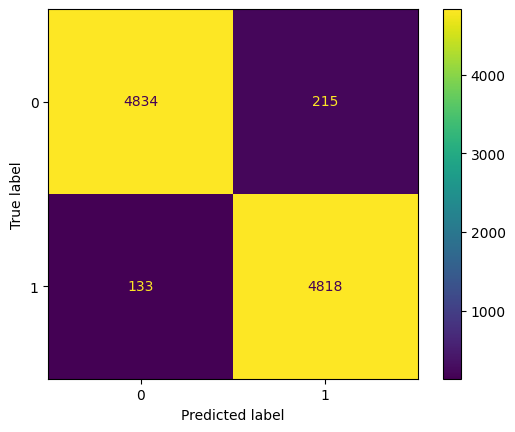

In [27]:



def __main__(file_path, learning_rate, batch_size, epochs):
    loss_fn = nn.CrossEntropyLoss()
    device = select_device()
    model = load_model('model_weights.pth',device)
    #model = load_model('model_weights.pth', device)
    train_on = input("Do you want to train? Yes(y), No(enter): ")
    if train_on:
        training_data, test_data = create_train_test_datasets(file_path, tokenizer)
        train_dataloader, test_dataloader = create_dataloader(training_data, test_data, batch_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        next_train = True
        while next_train:
            for t in range(epochs):
                print(f"Epoch {t+1}\n-------------------------------")
                train_loop(train_dataloader, model, loss_fn, optimizer, device)
                test_loop(test_dataloader, model, loss_fn, device)
            print("Done! Saving process...")
            torch.save(model.state_dict(), 'model_weights.pth')
            print(f"Best Accuracy: {(100*best_correct):>0.1f}% Using Learning Rate: {learning_rate}")
            stop_train = input("Should we continue training? No(Any) Yes(Enter) -> ")
            if stop_train:
                next_train = False
            else:
                change_lr = input("Change the learning rate? Yes(Any) No(Enter) -> ")
                if change_lr:
                    try:
                        learning_rate = float(input("New learning rate: "))
                    except:
                        print("Ignoring new learning rate")
                change_epochs = input(f"Change the number of epochs ({epochs})? Yes(Any) No(Enter) -> ")
                if change_epochs:
                    try:
                        epochs = int(input("New number of epochs: "))
                    except:
                        print("Ignoring new number of epochs")
    else:
        training_data, test_data = create_train_test_datasets(file_path, tokenizer)
        _, test_dataloader = create_dataloader(training_data, test_data, batch_size)
        test_loop(test_dataloader, model, loss_fn, device)

if __name__ == '__main__':
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    best_correct = 0
    best_weights = None
    file_path = 'IMDB Dataset.csv'
    learning_rate = 0.00001
    batch_size = 100
    epochs = 10
    __main__(file_path, learning_rate, batch_size, epochs)